# Import packages

In [2]:
import pandas as pd
import numpy as np
import os
from anndata import read_h5ad
from sklearn.neighbors import NearestNeighbors


import warnings
warnings.filterwarnings('ignore')
import sys

# sys.path.append('/data/yosef2/users/chenling/scVI/')
sys.path.append('../../utils/')
# from annotations_utils import *
import scvi
print(scvi.__version__)

import os
os.getcwd()

import logging
import os
import pickle
from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from hyperopt import hp

from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer, SemiSupervisedTrainer
from scvi.models import VAE, SCANVI
from copy import deepcopy

from scvi.dataset.anndataset import AnnDatasetFromAnnData

import scanpy as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

from anndata import read_h5ad
from anndata import AnnData

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

n_epochs = 150
show_plot = True
test_mode = False
use_batches = True
use_cuda = True
lr = 1e-3
retrain=True


sc.logging.print_versions()

[2020-03-09 16:25:27,002] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.


0.5.0
scanpy==1.4.5.post2 anndata==0.6.22 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


# Gene lists

In [3]:
pwd

'/home/angela/sapiens/tabula-sapiens/muscle-stem-cells'

In [4]:
disease_genes = pd.read_csv('disease_genes.csv')
disease_genes

,Symbol,Name,disease
0,CAPN3,Calpain3,LGMD
1,CAV3,Caveolin3,LGMD
2,DYSF,Dysferlin,LGMD
3,DTNA,DystrobrevinA,LGMD
4,DTNB,DystrobrevinB,LGMD
5,DAG1,Dystroglycan,LGMD
6,DMD,Dystrophin,Duchenne
7,DRP2,DystrophinRelatedProtein2,LGMD
8,EMD,Emerin,Emery-Dreyfuss
9,FKTN,Fukutin,LGMD


In [5]:
stemness_genes = pd.read_csv('stemness_genes.csv')
stemness_genes

,Symbol,state
0,PAX7,quiescence
1,PAX3,quiescence
2,MYF5,quiescence
3,CALCR,quiescence
4,SPRY1,quiescence
5,NOTCH3,quiescence
6,NOTCH1,quiescence
7,HEY1,quiescence
8,HEYL,quiescence
9,HES,quiescence


# Load data human

In [2]:
data_path = '../../data-objs/pilot1/FinalAnnotation/'

In [3]:
import os
#os.listdir(data_path)

In [109]:
adata_human = read_h5ad('../data-objs/pilot1/TSP1_objs_browser/TSP1_muscle.h5ad')
adata_human

AnnData object with n_obs × n_vars = 7502 × 21301 
    obs: 'batch_id', 'compartment_prediction', 'leiden', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'pancreas_prediction', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'Compartment Prediction_colors', 'Pancreas Prediction_colors', 'Smoothed Compartment Prediction_colors', 'leiden', 'neighbors', 'pca', 'smooth_comp2_colors', 'smooth_comp_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [110]:
set(adata_human.obs['scANVI_organ_alternate_training_free_annotation'])

{'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'capillary endothelial cell',
 'endothelial cell of artery',
 'endothelial cell of vascular tree',
 'macrophage',
 'mast cell',
 'mesenchymal stem cell',
 'multi-potent skeletal muscle stem cell',
 'myoblast',
 'natural killer cell',
 'skeletal muscle fiber',
 'smooth muscle cell',
 'tendon cell'}

In [111]:
adata_human = adata_human[
    adata_human.obs['scANVI_organ_alternate_training_free_annotation'].isin(
        ['multi-potent skeletal muscle stem cell','myoblast','skeletal muscle fiber','smooth muscle cell'])].copy()
adata_human

AnnData object with n_obs × n_vars = 2551 × 21301 
    obs: 'batch_id', 'compartment_prediction', 'leiden', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'pancreas_prediction', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'Compartment Prediction_colors', 'Pancreas Prediction_colors', 'Smoothed Compartment Prediction_colors', 'leiden', 'neighbors', 'pca', 'smooth_comp2_colors', 'smooth_comp_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [112]:
disease_genes_human = disease_genes[disease_genes['Symbol'].isin(adata_human.var_names)]
stemness_genes_human = stemness_genes[stemness_genes['Symbol'].isin(adata_human.var_names)]

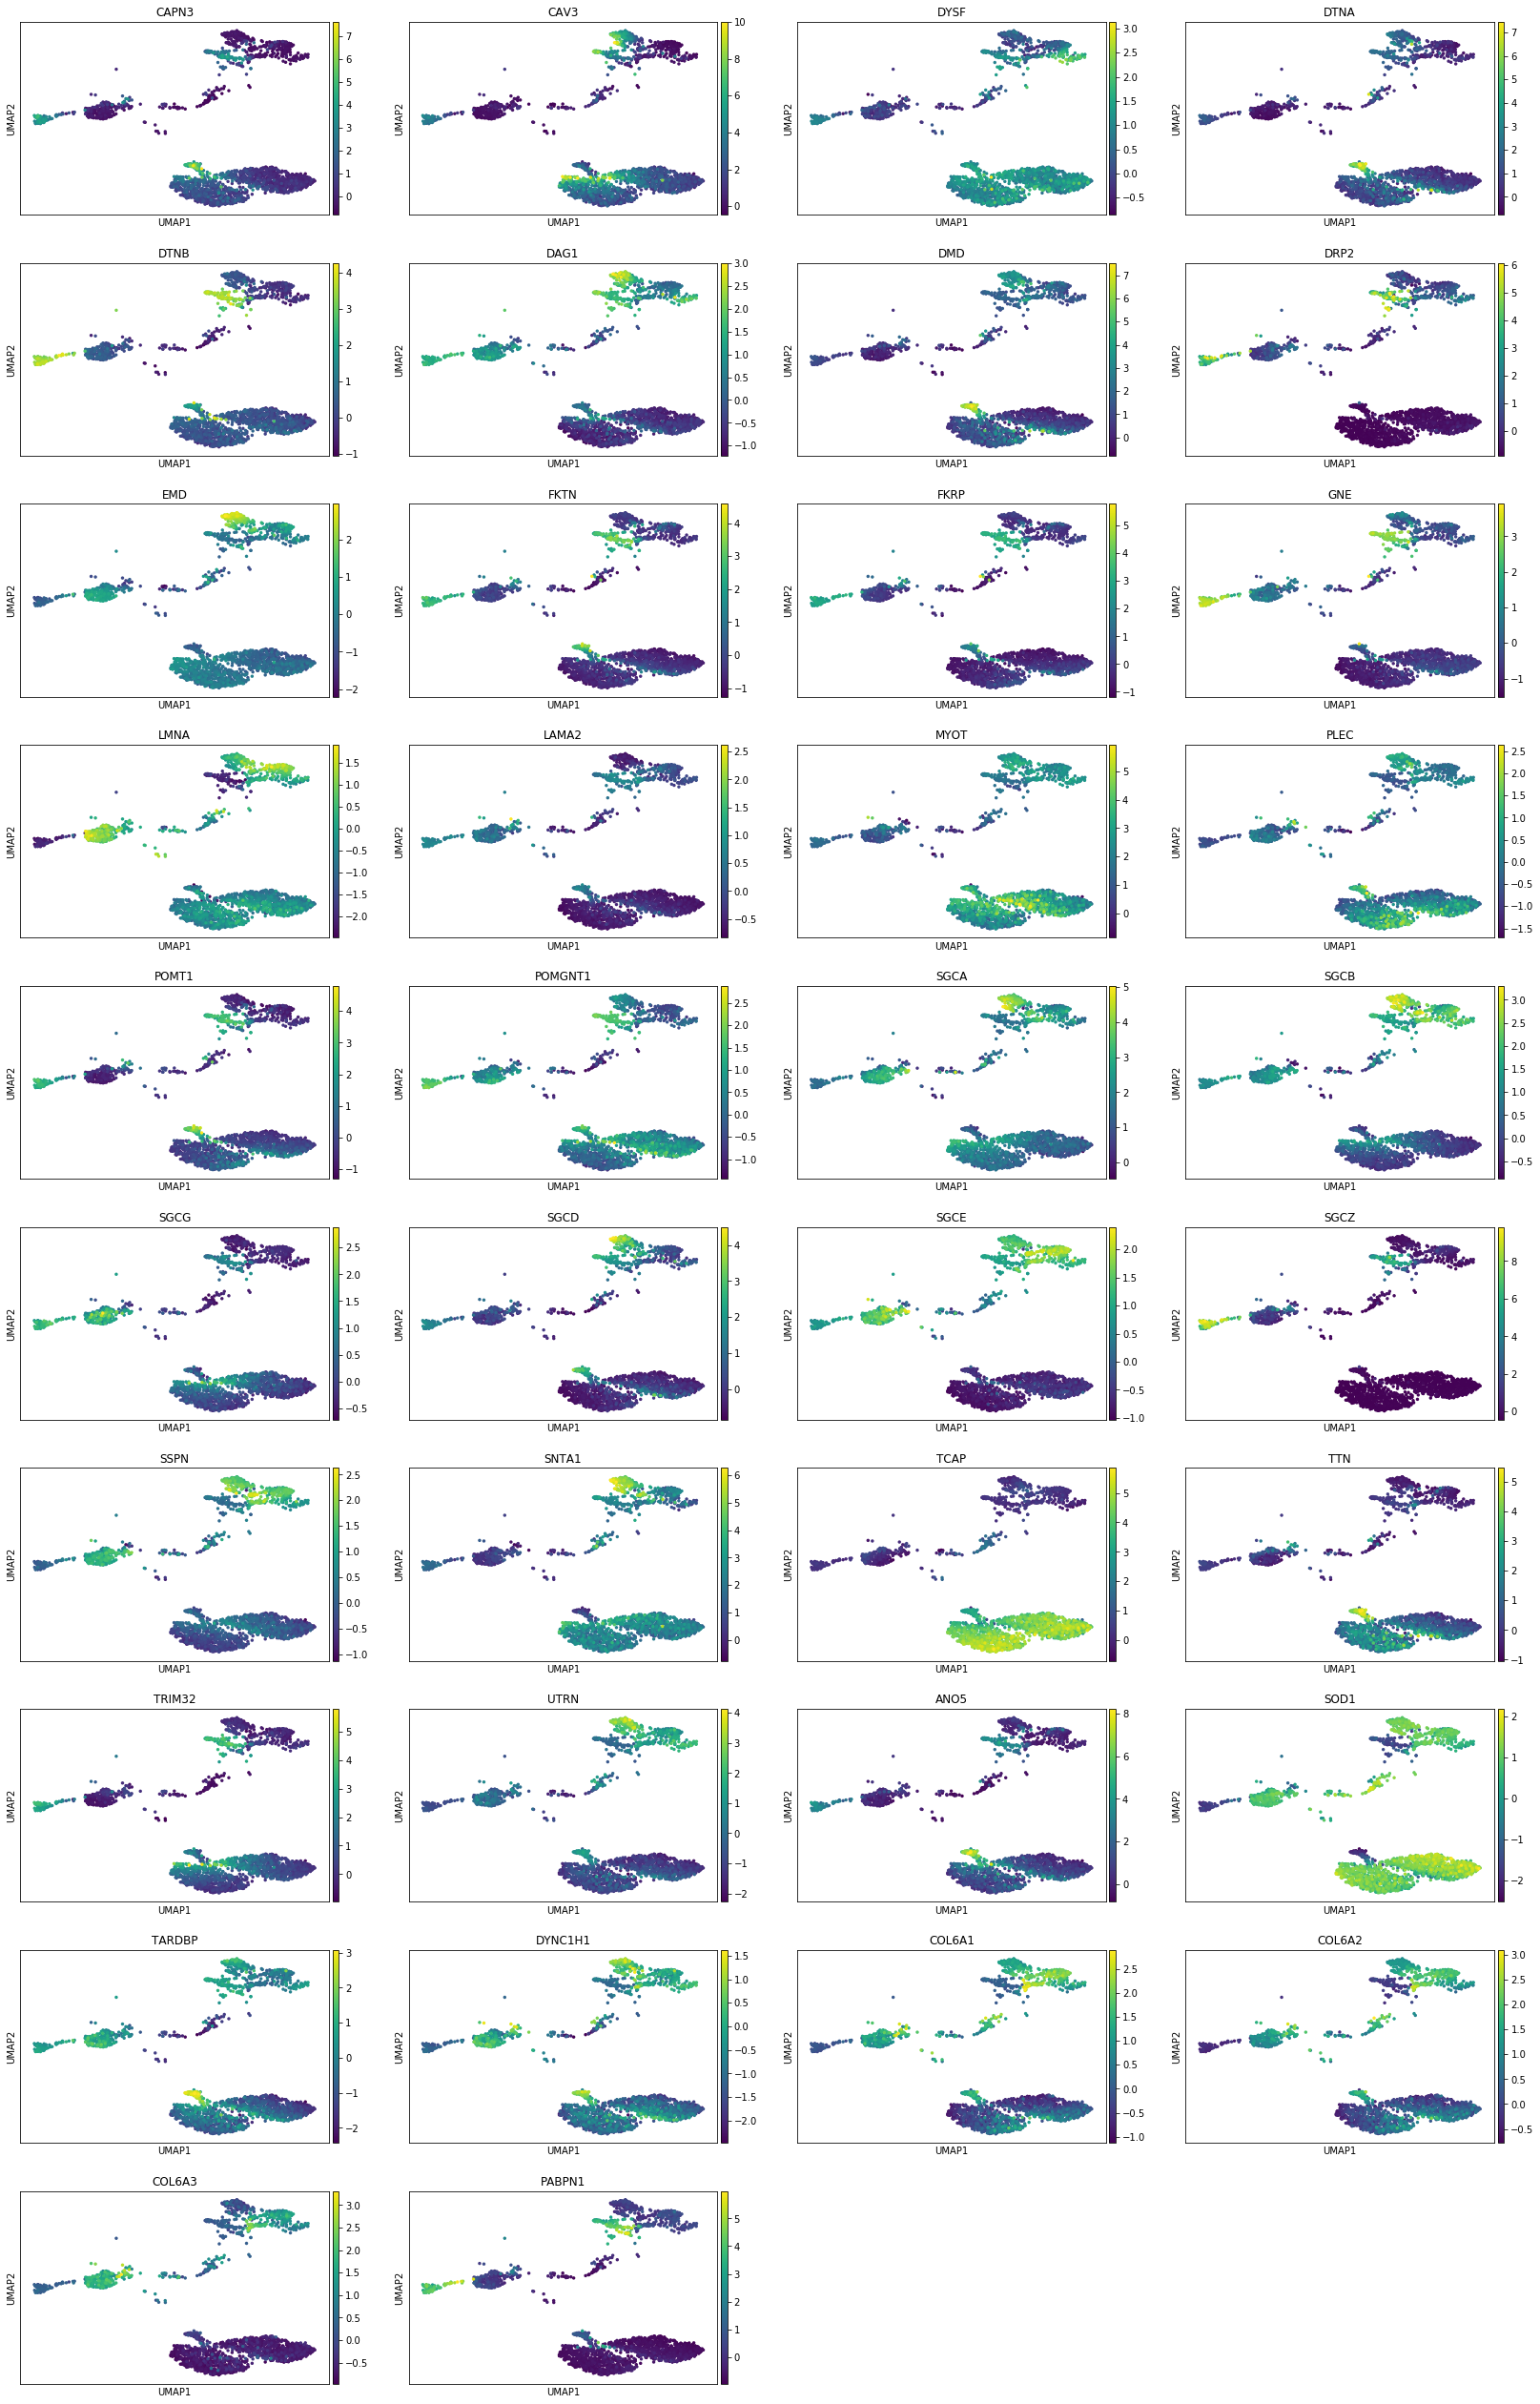

In [113]:
sc.pl.umap(adata_human,color=disease_genes_human['Symbol'])

In [134]:
stemness_genes_human#[stemness_genes_human['state']=='quiescence']['Symbol']

,Symbol,state
0,PAX7,quiescence
1,PAX3,quiescence
2,MYF5,quiescence
3,CALCR,quiescence
4,SPRY1,quiescence
5,NOTCH3,quiescence
6,NOTCH1,quiescence
7,HEY1,quiescence
8,HEYL,quiescence
10,MYOD1,activation


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


... storing 'stemness' as categorical


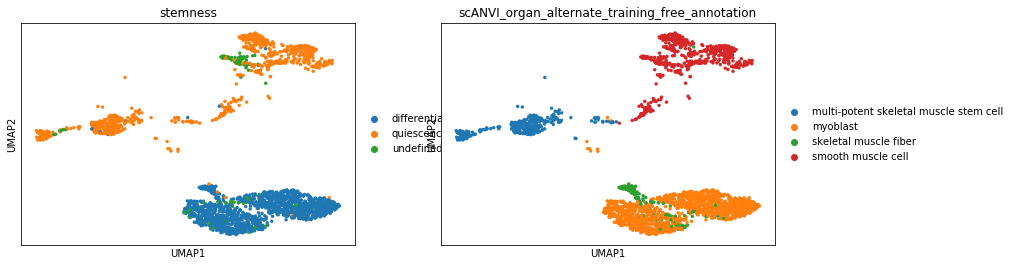

In [133]:
sc.tl.score_genes_cell_cycle(adata_human,
                             g2m_genes=stemness_genes_human[stemness_genes_human['state']=='quiescence']['Symbol'],
                            s_genes=stemness_genes_human[stemness_genes_human['state']=='differentiation']['Symbol'])

adata_human.obs = adata_human.obs.rename(columns={'S_score':'differentiation_score','G2M_score':'quiescence_score'})#,'phase':'stemness'})
# adata_human.obs['stemness'] = adata_human.obs['stemness'].astype(str)
adata_human.obs['stemness'] = adata_human.obs['phase'].replace(['G1','G2M','S'],['undefined','quiescence','differentiation'])
adata_human.obs = adata_human.obs.drop('phase',axis=1)


sc.pl.umap(adata_human,color=['stemness','scANVI_organ_alternate_training_free_annotation'])


In [130]:
adata_human.obs = adata_human.obs.drop('stemness',axis=1)

In [81]:

adata_human.obs

,batch_id,compartment_prediction,leiden,log1p_total_counts,manual_cell_ontology,manual_free_annotation,method,n_genes,pancreas_prediction,scANVI_organ_alternate_training_cell_ontology,...,scANVI_organ_free_annotation,subtissue,tissue,tissue_method,differentiation,quiescence,stemness,differentiation,quiescence,stemness
index,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGATGTTAG-1-4,12,mixed,11,8.705663,multi-potent skeletal muscle stem cell,multi-potent skeletal muscle stem cell,10x,1970,not pancreas,multi-potent skeletal muscle stem cell,...,multi-potent skeletal muscle stem cell,muscle,muscle,muscle_10x,-0.107493,1.205517,G2M,-0.107493,1.205517,G2M
AAACGAATCGTCGGGT-1-4,12,immune,1,6.664409,myoblast,myoblast,10x,365,not pancreas,myoblast,...,myoblast,muscle,muscle,muscle_10x,0.296642,-0.368003,S,0.296642,-0.368003,S
AAACGAATCTGGGAGA-1-4,12,immune,1,7.533159,myoblast,myoblast,10x,576,not pancreas,myoblast,...,myoblast,muscle,muscle,muscle_10x,0.231362,-0.520762,S,0.231362,-0.520762,S
AAACGCTAGCAGCGAT-1-4,12,immune,1,6.970730,myoblast,myoblast,10x,475,not pancreas,skeletal muscle fiber,...,myoblast,muscle,muscle,muscle_10x,0.462053,-0.329759,S,0.462053,-0.329759,S
AAAGGTATCACATTGG-1-4,12,mixed,11,9.000607,multi-potent skeletal muscle stem cell,multi-potent skeletal muscle stem cell,10x,2353,not pancreas,multi-potent skeletal muscle stem cell,...,multi-potent skeletal muscle stem cell,muscle,muscle,muscle_10x,0.323793,0.623992,G2M,0.323793,0.623992,G2M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B107924_P16_S108.homo,3,mixed,7,9.866408,smooth muscle cell,smooth muscle cell,ss2,384,not pancreas,smooth muscle cell,...,smooth muscle cell,muscle,muscle,Muscle_ss2,-0.936241,1.114195,G2M,-0.936241,1.114195,G2M
B107924_P17_S109.homo,3,mixed,22,13.462661,multi-potent skeletal muscle stem cell,multi-potent skeletal muscle stem cell,ss2,982,not pancreas,multi-potent skeletal muscle stem cell,...,multi-potent skeletal muscle stem cell,muscle,muscle,Muscle_ss2,-1.267205,0.762892,G2M,-1.267205,0.762892,G2M
B107924_P20_S112.homo,3,mixed,14,11.815531,smooth muscle cell,smooth muscle cell,ss2,712,not pancreas,smooth muscle cell,...,smooth muscle cell,muscle,muscle,Muscle_ss2,-1.228242,0.697003,G2M,-1.228242,0.697003,G2M


In [37]:
adata.obs['tissue'] = adata.obs['tissue'].str.lower()
adata.obs['subtissue'] = adata.obs['tissue']
adata.obs.loc[adata.obs['tissue'].isin(
    ['exopancreas1','endopancreas','exopancreas2','pancreasendocrine', 'pancreasexocrine']),'tissue'] = 'pancreas'

adata.obs['method'] = [tt.split('_')[1] for tt in adata.obs['Tissue Tech']]

adata.obs = adata.obs.drop(
    ['Compartment Prediction', '10X_plate','Compartment', 'S_score', 'G2M_score', 'phase'],
    axis=1)

adata.obs = adata.obs.rename(columns={"Tissue Tech": "tissue_method",
                                      "Pancreas Prediction" : "pancreas_prediction",
                                     "Manual Annotation Round 2": "manual_free_annotation",
                                     "Manual Annotation Round 2 Ontology Terms": "manual_cell_ontology",
                                     "Smoothed Compartment Prediction": "compartment_prediction",
                                     "scANVI Prediction By Organ": "scANVI_organ_free_annotation",
                                     "scANVI Prediction By Organ-Compartment": "scANVI_organ_compartment_free_annotation",
                                     "scANVI Prediction By Organ with Alternate Training": "scANVI_organ_alternate_training_free_annotation",
                                     "scANVI Prediction By Organ-Compartment with Alternate Training": "scANVI_organ_compartment_alternate_training_free_annotation",
                                     "scANVI Prediction Ontology Term By Organ": "scANVI_organ_cell_ontology",
                                     "scANVI Prediction Ontology Term By Organ-Compartment": "scANVI_organ_compartment_cell_ontology",
                                     "scANVI Prediction Ontology Term By Organ with Alternate Training": "scANVI_organ_alternate_training_cell_ontology",
                                     "scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training": "scANVI_organ_compartment_alternate_training_cell_ontology"})

adata.obs['compartment_prediction'] = adata.obs['compartment_prediction'].str.lower()

adata.obs = adata.obs.reindex(sorted(adata.obs.columns), axis=1)

adata

AnnData object with n_obs × n_vars = 68451 × 21301 
    obs: '10X_plate', 'Compartment', 'G2M_score', 'S_score', 'batch_id', 'leiden_scvi', 'leiden_scvi_split', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'phase', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'neighbors'
    obsm: 'X_scvi', 'X_umap'

In [5]:
set(adata.obs['pancreas_prediction']),set(adata.obs['compartment_prediction'])

({'not pancreas', 'pancreas'},
 {'endothelial', 'epithelial', 'immune', 'mixed', 'stromal'})

In [6]:
adata.obs.head()

,batch_id,compartment_prediction,leiden,log1p_total_counts,manual_cell_ontology,manual_free_annotation,method,n_genes,pancreas_prediction,scANVI_organ_alternate_training_cell_ontology,scANVI_organ_alternate_training_free_annotation,scANVI_organ_cell_ontology,scANVI_organ_compartment_alternate_training_cell_ontology,scANVI_organ_compartment_alternate_training_free_annotation,scANVI_organ_compartment_cell_ontology,scANVI_organ_compartment_free_annotation,scANVI_organ_free_annotation,subtissue,tissue,tissue_method
index,,,,,,,,,,,,,,,,,,,,
AAACGAAAGCATCCCG-1-0,8,epithelial,63,6.467699,cell,unassigned,10x,500,not pancreas,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,endopancreas,pancreas,endopancreas_10x
AAAGGATTCTCGCCTA-1-0,8,epithelial,25,7.651596,cell,unassigned,10x,384,pancreas,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,endopancreas,pancreas,endopancreas_10x
AAAGGGCGTGGGCTCT-1-0,8,mixed,15,7.617760,pancreatic acinar cell,pancreatic acinar cell,10x,215,pancreas,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,endopancreas,pancreas,endopancreas_10x
AACAAAGTCGAAGCCC-1-0,8,epithelial,48,6.666957,pancreatic acinar cell,pancreatic acinar cell,10x,343,pancreas,pancreatic ductal cell,pancreatic ductal cell,pancreatic acinar cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,endopancreas,pancreas,endopancreas_10x
AACAACCTCAACGAGG-1-0,8,endothelial,64,8.036250,endothelial cell,endothelial cell,10x,1590,not pancreas,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endopancreas,pancreas,endopancreas_10x


# Load data mouse

In [36]:
adata_mouse = sc.read_h5ad(
    '../../../maca/tabula-muris-senis/0_data_ingest/01_figure_1/tabula-muris-senis-droplet-official-raw-obj.h5ad')
adata_mouse

AnnData object with n_obs × n_vars = 245389 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [37]:
set(adata_mouse.obs['tissue'])

{'Bladder',
 'Fat',
 'Heart_and_Aorta',
 'Kidney',
 'Large_Intestine',
 'Limb_Muscle',
 'Liver',
 'Lung',
 'Mammary_Gland',
 'Marrow',
 'Pancreas',
 'Skin',
 'Spleen',
 'Thymus',
 'Tongue',
 'Trachea'}

In [38]:
adata_mouse = adata_mouse[adata_mouse.obs['tissue']=='Limb_Muscle']
adata_mouse

View of AnnData object with n_obs × n_vars = 28867 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [45]:
set(adata_mouse.obs['cell_ontology_class'])

{'B cell',
 'Schwann cell',
 'T cell',
 'endothelial cell',
 'macrophage',
 'mesenchymal stem cell',
 'skeletal muscle cell',
 'skeletal muscle satellite cell',
 'smooth muscle cell'}

In [ ]:
sc.pp.pca(adata_mouse)
sc.pp.neighbors(adata_mouse)
sc.tl.umap(adata_mouse)

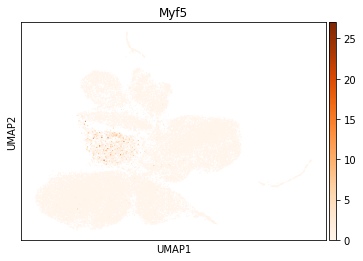

In [52]:
sc.pl.umap(adata_mouse,color='Myf5',cmap='Oranges')

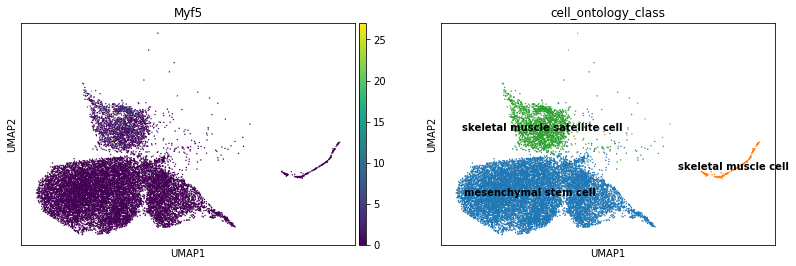

In [51]:
sc.pl.umap(
    adata_mouse[adata_mouse.obs['cell_ontology_class'].isin(
        ['skeletal muscle satellite cell','skeletal muscle cell','mesenchymal stem cell'])],
    color=['Myf5','cell_ontology_class'], legend_loc='on data')

# Load data lemur

# Write objs for browser

In [7]:
adata.write('../../data-objs/pilot1/TSP1_objs_browser/TSP1_all.h5ad')

... storing 'compartment_prediction' as categorical
... storing 'method' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical


## Write compartment objs

In [8]:
for c in list(set(adata.obs['compartment_prediction'])):
    adata_comp = adata[adata.obs['compartment_prediction']==c].copy()
    
    if adata_comp.shape[0]>0:
        sc.pp.pca(adata_comp)
        sc.pp.neighbors(adata_comp, n_neighbors=20, n_pcs=30, use_rep="X_scvi")
        sc.tl.umap(adata_comp)
        sc.tl.leiden(adata_comp)
        sc.tl.tsne(adata_comp, use_rep = 'X_scvi')
        adata_comp.write_h5ad('../../data-objs/pilot1/TSP1_objs_browser/TSP1_all_'+c+'.h5ad')
    else:
        print("there is no cells to put in "+c)

computing PCA with n_comps = 50
    finished (0:00:10)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)
running Leiden clustering
    finished: found 35 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:18)
computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:03:15)
computing PCA with n_comps = 50
    finished (0:00:02)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden',

## Write tissue objs

In [9]:
for t in list(set(adata.obs['tissue'])):
    adata_tiss = adata[adata.obs['tissue']==t].copy()
    
    if adata_tiss.shape[0]>0:
        sc.pp.pca(adata_tiss)
        sc.pp.neighbors(adata_tiss, n_neighbors=20, n_pcs=30, use_rep="X_scvi")
        sc.tl.umap(adata_tiss)
        sc.tl.leiden(adata_tiss)
        sc.tl.tsne(adata_tiss, use_rep = 'X_scvi')
        adata_tiss.write_h5ad('../../data-objs/pilot1/TSP1_objs_browser/TSP1_'+t+'.h5ad')
    else:
        print("there is no cells to put in "+t)

computing PCA with n_comps = 50
    finished (0:00:07)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)
running Leiden clustering
    finished: found 36 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:51)
computing PCA with n_comps = 50
    finished (0:00:02)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden',

## Write tissue_compartment objs

In [25]:
for t in ['blood','pancreas']:#list(set(adata.obs['tissue'])):
    adata_tiss = adata[adata.obs['tissue']==t].copy()
    if adata_tiss.shape[0]>0:
        
        for c in list(set(adata_tiss.obs['compartment_prediction'])):
            adata_comp = adata_tiss[adata_tiss.obs['compartment_prediction']==c].copy()

            if adata_comp.shape[0]>0:
                
                try:
                    sc.pp.pca(adata_comp)
                except:
                    sc.pp.pca(adata_comp,n_comps=adata_comp.shape[0]-1)
                
                sc.pp.neighbors(adata_comp, n_neighbors=20, n_pcs=30, use_rep="X_scvi")
                
                try:
                    sc.tl.umap(adata_comp)
                    sc.tl.leiden(adata_comp)
                    sc.tl.tsne(adata_comp, use_rep = 'X_scvi')
                    adata_comp.write_h5ad('../../data-objs/pilot1/TSP1_objs_browser/TSP1_'+t+'_'+c+'.h5ad')
                
                except:
                    print("there is no cells to put in "+t+" "+c)
            
            else:
                print("there is no cells to put in "+t+" "+c)
    
    
    else:
        print("there is no cells to put in "+t)

computing PCA with n_comps = 50
    finished (0:00:07)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:46)
computing PCA with n_comps = 50
    finished (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', 